In [22]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [23]:
MODEL_PATH = "models/model_H32_L1_LR0.001_BS1024_S7_PAT10.pt"
LOG_PATH = "logs/train_loss_H32_L1_LR0.001_BS1024_S7_PAT10.csv"
INPUT_CSV = "european_capitals_weather_combined.csv"
TARGET_CITY = "Budapest"
TARGET_FEATURE = f"{TARGET_CITY}_tmax"
WINDOW_SIZE = 7


In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [25]:
# --- Adatok előkészítése (48 oszlopra szűkítve, NaN-mentesen) ---
df = pd.read_csv(INPUT_CSV)
df = df.drop(columns=["time"], errors="ignore")

# Csak azokat a város-jellemző kombinációkat használjuk, amelyek tanításkor is szerepeltek
used_suffixes = ["tavg", "tmin", "tmax", "prcp", "wspd"]
selected_columns = [col for col in df.columns if col.split("_")[-1] in used_suffixes]

# Kiszűrjük azokat az oszlopokat, ahol van bármilyen hiányzó érték
clean_columns = [col for col in selected_columns if not df[col].isnull().any()]

# Ellenőrizzük, hogy valóban 48 oszlopot kaptunk
assert len(clean_columns) == 48, f"{len(clean_columns)} oszlopot találtunk, de 48-at vártunk. Ellenőrizd az adatfájlt."

df = df[clean_columns]

# A bemeneti adatok normalizálása (X), de y változatlanul marad
features = df.values.astype(np.float32)

# Célváltozó oszlop kinyerése eredeti skálán
target_idx = list(df.columns).index(TARGET_FEATURE)
target_series = features[:, target_idx].copy()  # y eredeti értéken marad

# Bemeneti adatok normalizálása (de csak az X)
scaler = lambda x: (x - np.nanmean(x)) / (np.nanstd(x) + 1e-6)
features = scaler(features)

# Sliding window
X, y = [], []
for i in range(WINDOW_SIZE, len(features)):
    X.append(features[i - WINDOW_SIZE:i])
    y.append(target_series[i])  # y itt már nem normalizált

X = np.array(X)
y = np.array(y)

In [26]:
print("CUDA elérhető:", torch.cuda.is_available())
print("CUDA verzió:", torch.version.cuda)
print("PyTorch build CUDA-támogatással:", torch.backends.cudnn.enabled)
print("Alapértelmezett eszköz:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA elérhető: True
CUDA verzió: 12.1
PyTorch build CUDA-támogatással: True
Alapértelmezett eszköz: cuda


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=X.shape[2], hidden_size=32, num_layers=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()


C:\Users\Tomi\AppData\Local\Temp\ipykernel_11472\194507650.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=devi

LSTMModel(
  (lstm): LSTM(48, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [28]:
with torch.no_grad():
    inputs = torch.tensor(X, dtype=torch.float32).to(device)
    preds = model(inputs).squeeze().cpu().numpy()


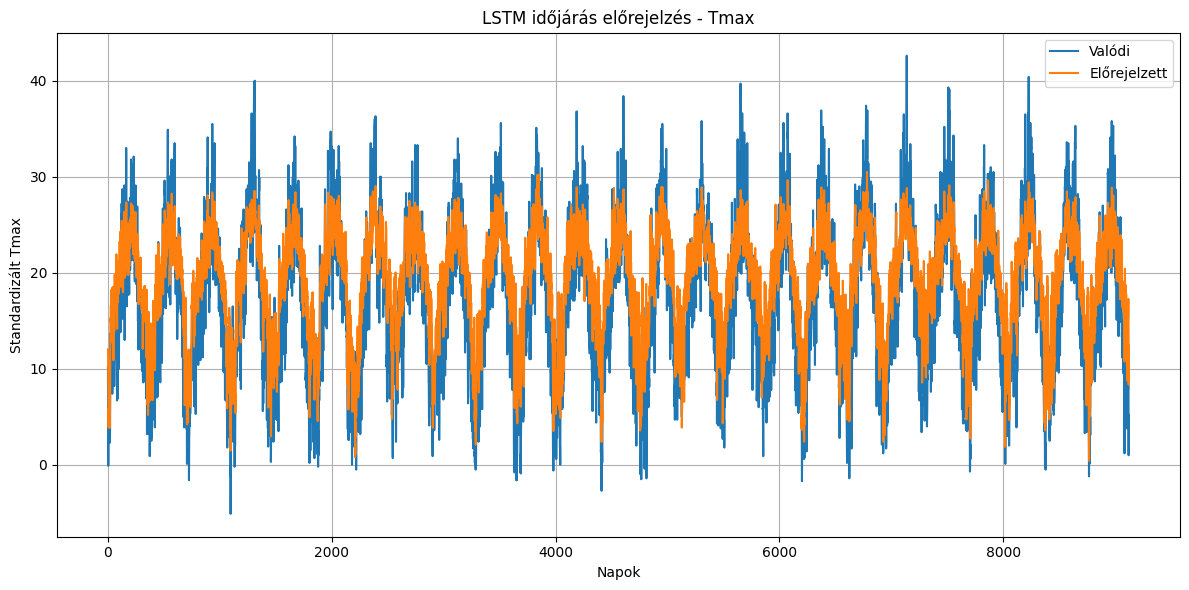

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(y, label="Valódi")
plt.plot(preds, label="Előrejelzett")
plt.title("LSTM időjárás előrejelzés - Tmax")
plt.xlabel("Napok")
plt.ylabel("Standardizált Tmax")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
